In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
!pip install pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [3]:
class Dataset_torch(Dataset):

    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data['y'])    

    def __getitem__(self, idx):
        
        inputs = [self.data['x1'][idx],self.data['x2'][idx].float()]
        return inputs, self.data['y'][idx]
        

In [4]:
data_18 = torch.load('/content/drive/MyDrive/sar_img/dataset/tensors_2018.pt')
dataset_2018 = Dataset_torch(data_18)
data_loader_2018 = torch.utils.data.DataLoader(dataset=dataset_2018, batch_size=1024,num_workers=2)

In [5]:
def find_same(list1,list2):
    for i in list1:
      for j in list2:
        if torch.abs(i-j)<0.0005:
          return i

In [6]:
pi = torch.tensor(math.pi)

In [7]:
latitude_list = []
for i in range(len(data_18['x2'])):
  sin_list = [torch.asin(data_18['x2'][i][24]), pi-torch.asin(data_18['x2'][i][24])]
  cos_list = [torch.acos(data_18['x2'][i][25]), -torch.acos(data_18['x2'][i][25])]
  latitude_list.append( -(find_same(sin_list,cos_list)-pi/2)*180/pi)

In [8]:
longitude_list = []
for i in range(len(data_18['x2'])):
  sin_list = [torch.asin(data_18['x2'][i][26]), pi-torch.asin(data_18['x2'][i][26]), -pi-torch.asin(data_18['x2'][i][26])]
  cos_list = [torch.acos(data_18['x2'][i][27]), -torch.acos(data_18['x2'][i][27])]
  longitude_list.append( (find_same(sin_list,cos_list)+pi)*180/pi)

In [9]:
longitude_list = np.array( longitude_list)
latitude_list = np.array(latitude_list)

In [10]:
class Net_spectral(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        # self.conv4 = nn.Conv2d(256, 512, 3)

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)

        self.fc512_n1 = nn.Linear(256, 256)
        self.fc512_n2 = nn.Linear(256, 256)

    def forward(self, x):
        x = self.maxpooling2d(F.relu(self.conv1(x)))
        x = self.maxpooling2d(F.relu(self.conv2(x)))
        x = self.maxpooling2d(F.relu(self.conv3(x)))
        # x = self.maxpooling2d(F.relu(self.conv4(x)))
        x= self.globalmaxpooling2d(x)
        x = F.relu(self.fc512_n1(torch.squeeze(x)))

        x = F.relu(self.fc512_n2(x))
        x = self.dropout(x)
        return x

class MLP_output(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)
        self.dropout_n3 = nn.Dropout(p=0.5)


        self.fc256 = nn.Linear(256, 256)

        # self.fc1024_512 = nn.Linear(1024, 512)
        self.fc512_256 = nn.Linear(512, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_2 = nn.Linear(128,2)

    def forward(self, x):


        # x = F.relu(self.fc1024_512(x))
        # x = self.dropout_n1(x)
        # x = F.relu(self.fc512_256(x))
        # x = self.dropout_n2(x)
        x = F.relu(self.fc256_128(x))
        x = self.dropout_n3(x)

        output = F.softplus(self.fc128_2(x))

        return output

class Net_cwave(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim = 1)


        self.fc10_64 = nn.Linear(10, 64)
        self.fc64_128 = nn.Linear(64, 128)
        self.fc128_256 = nn.Linear(128, 256)
        self.fc256_512 = nn.Linear(256, 512)
        self.fc512_1024 = nn.Linear(512, 1024)
        self.fc1024_2048 = nn.Linear(1024,2048)

    def forward(self, x):
        x = F.relu(self.fc10_64(x[:,22:]))
        x = F.relu(self.fc64_128(x))
        x = F.relu(self.fc128_256(x))
        x = F.relu(self.fc256_512(x))
        x = F.relu(self.fc512_1024(x))
        x = F.relu(self.fc1024_2048(x))
        x = x.view(-1,8,256)

        x = self.softmax(x)
        x = self.dropout(x)
        return x

# combination of two NN
class Net_comb(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.maxpooling2d = nn.MaxPool2d(2, 2)
        self.globalmaxpooling2d = nn.AdaptiveMaxPool2d(1)

        self.dropout_n1 = nn.Dropout(p=0.5)
        self.dropout_n2 = nn.Dropout(p=0.5)

        self.fc256 = nn.Linear(256, 256)
        self.fc256_128 = nn.Linear(256, 128)
        self.fc128_1 = nn.Linear(128, 1)

        self.net_cwave = Net_cwave()

        self.net_spectral_n1 = Net_spectral()
        self.net_spectral_n2 = Net_spectral()
        self.net_spectral_n3 = Net_spectral()
        self.net_spectral_n4 = Net_spectral()
        self.net_spectral_n5 = Net_spectral()
        self.net_spectral_n6 = Net_spectral()
        self.net_spectral_n7 = Net_spectral()
        self.net_spectral_n8 = Net_spectral()

        self.mlp_out = MLP_output()
        # self.mlp_out_2 = MLP_output()

    def forward(self, x1,x2):

        output = torch.mean(self.net_cwave(x2),dim=2)

        return output
    def training_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2.float())


        loss_f = nn.GaussianNLLLoss()
        loss = loss_f(y_pre[:,0], torch.squeeze(y_true).float(),y_pre[:,1])
        # loss = F.mse_loss(torch.squeeze(y_pre), torch.squeeze(y_true).float())

        # Logging to TensorBoard by default
        self.log('train_loss', loss )

        return loss

    def validation_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2)

        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('val_loss', loss)

        return loss

    def test_step(self, batch, batch_idx):

        x, y_true = batch
        x1,x2 = x

        y_pre = self.forward(x1,x2)
        loss = F.mse_loss(y_pre[:,0], torch.squeeze(y_true))
        self.log('test_loss', loss)

        return loss

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience= 1)

        return { 'optimizer': optimizer, 'lr_scheduler': { 'scheduler': scheduler, 'monitor': 'val_loss', } }


In [11]:
model = Net_comb.load_from_checkpoint('/content/drive/MyDrive/sar_img/test_k8.ckpt')

In [12]:
index_plot = np.random.randint(low=0,high=len(data_18['x2']), size=10000)
model.eval()
result = model(data_18['x1'][index_plot],data_18['x2'][index_plot])

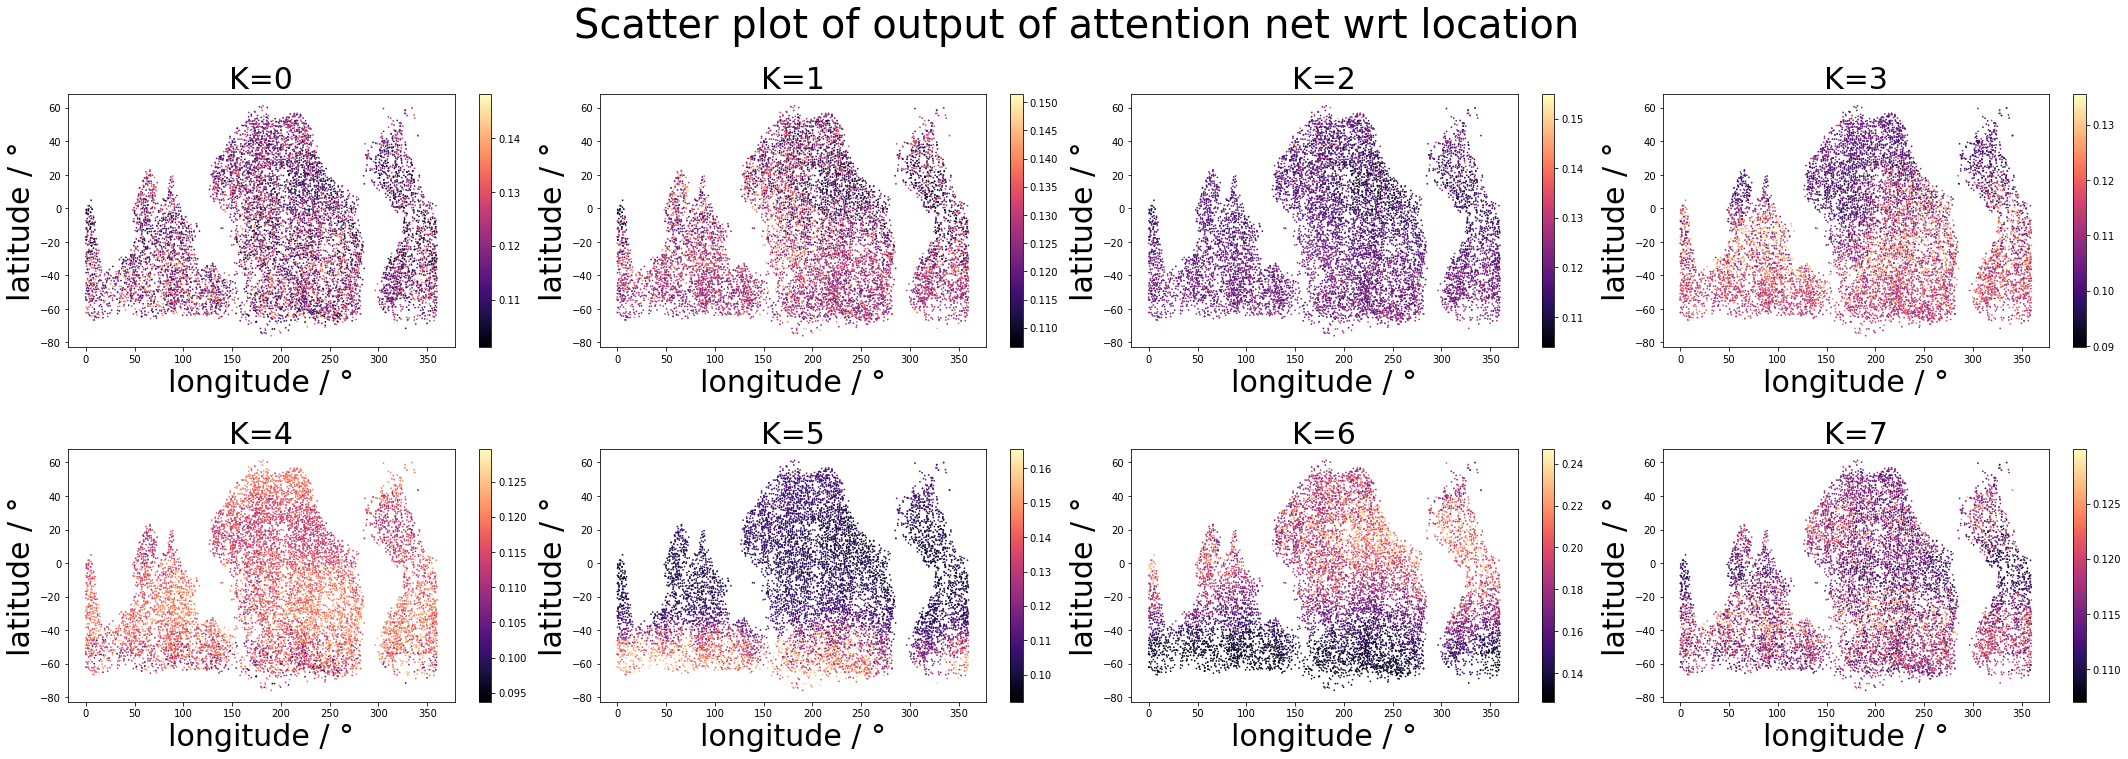

In [13]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 4,figsize=(30,10))
fig.suptitle('Scatter plot of output of attention net wrt location', fontsize=40,y=1.05)

for i in range(8):
    im = axes[int(i/4),i%4].scatter( -(longitude_list[index_plot]+90)%360, latitude_list[index_plot], s=0.5, c= result[:,i].detach().numpy(), cmap='magma')
    axes[int(i/4),i%4].set_title('K='+str(i), fontsize=30)
    axes[int(i/4),i%4].set_xlabel('longitude / °', fontsize=30)
    axes[int(i/4),i%4].set_ylabel('latitude / °', fontsize=30)
    fig.colorbar(im, ax=axes[int(i/4),i%4])
plt.subplots_adjust(wspace=0, hspace=5)
plt.tight_layout()


